## Imports

Prerequisites
* Install Python 3.12. At the time this was written, PyTorch did not support Python versions higher than 3.12.
* Create a virtual environment: `python -m venv .venv`.
* Activate the virtual environment: `.venv\Scripts\activate`
* Install required Python packages. Either
  * Use the latest versions: `pip install numpy matplotlib torch ipykernel`
  * Use the versions frozen in requirements.txt: `pip install -r requirements.txt`

Let's import some packages that will be used throught this notebook.

In [1]:
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# Sample Function

Let's define a simple function `f(x)` that we'd like to approximate. We'll take `n` samples uniformly spaced along the x-axis in the range from `(x0, x1)` and store the x and y coordinates in the variables `x`, and `y`,

Note that if you change the definition of `f(x)`, you may also have to adjust `x0`, `x1`, and `n` to get a representative
# set of samples over an interesting domain.

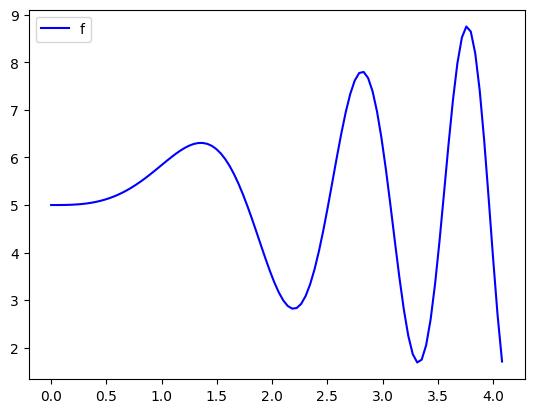

In [2]:
f = lambda x: np.sin(x**2) * x + 5

x0 = 0    # Left side of domain
x1 = 4    # Right side of domain
n = 100   # Number of samples

x = np.linspace(x0, x1 + (x1 - x0) * 2 / n, n + 2)
y = np.vectorize(f)(x)

plt.plot(x, y, label="f", color="blue")
plt.legend()
plt.show()

# Piecewise-Linear Approximation

We'll use a naive algorithm to generate a continuous, piecewise linear function that approximates `f(x)`, with a bias towards shorter line segments in regions where the slope of `f(x)` changes more rapidly.

This approximation will be stored in `segments`.

Note that if you change the definition of `f(x)` you may need to adjust the `error_total` and `error_max` parameters to get a decent approximation.

Approximating function f(x) with 32 linear segments.


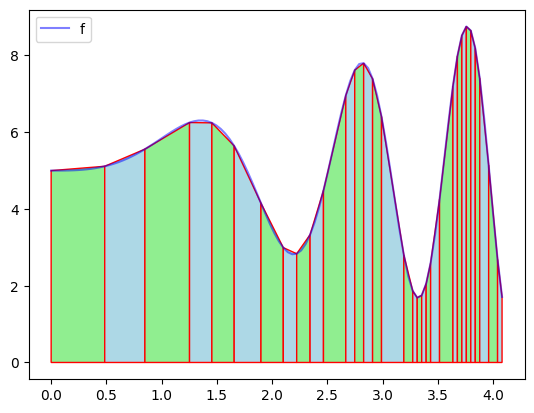

In [3]:
def compute_errors(x, y, i, j):
    if j - i == 1:
        return (0, 0, 0)
    m = (y[j - 1] - y[i]) / (x[j - 1] - x[i])
    b = y[i]
    errors = [abs((m * (x[k] - x[i])) + b - y[k]) for k in range(i, j)]
    return np.mean(errors), np.sum(errors), np.max(errors)


# Finds the longest run where the average error is less than epsilon
def next_piece(x, y, epsilon_total, epsilon_max, i):
    best_piece = None
    j = i + 1
    while j <= len(x):
        error = compute_errors(x, y, i, j)
        mean, total, max = error
        
        if total > epsilon_total:
            break
        if max > epsilon_max:
            break
        best_piece = (i, j, error)
        j += 1
    return best_piece


def piecewise(x, y, epsilon_total, epsilon_max, pieces):
    i = 0
    while i < len(x) - 1:
        piece = next_piece(x, y, epsilon_total, epsilon_max, i)
        pieces.append(piece)
        i = piece[1] - 1
    return pieces


# segments = piecewise(x, y, 0.05, [])
segments = piecewise(x, y, 0.35, .1, [])

fig, ax = plt.subplots()
for i, s in enumerate(segments):
    vertices = [
        (x[s[0]], 0),
        (x[s[0]], y[s[0]]),
        (x[s[1] - 1], y[s[1] - 1]),
        (x[s[1] - 1], 0),
    ]
    color = "lightgreen" if i % 2 == 0 else "lightblue"
    polygon = patches.Polygon(
        vertices, closed=True, fill=True, edgecolor="r", facecolor=color
    )
    ax.add_patch(polygon)

print(f"Approximating function f(x) with {len(segments)} linear segments.")

plt.plot(x, y, label="f", color="blue", alpha=0.5)
# plt.scatter([x[s[0]] for s in segments], [y[s[0]] for s in segments], color="red", label="Training samples")
plt.legend()
plt.show()

## Building a deep learning model to approximate `f(x)`

We can get a good approximation of `f(x)` using a model with two [dense layers](https://en.wikipedia.org/wiki/Layer_(deep_learning)), the first of which will use [RELU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation.

Let's create a a function to compute the weights and biases for this model. Given 
* **x:** samples of the domain of function `f(x)`
* **y:** corresponding values of `f(x)`
* **segments:** an array of `n` ranges of indices into `x` and `y`. 

Each range defines the extent of a line segment.
returns
* **m1:** a `1 x 2n` matrix of weights for the first layer
* **b1:** a `1 x 2n` vector of biases for the first layer
* **m2:** a `2n x 1` matrix of weights for the second layer
* **b2:** a `1 x 1` vector containing the single bias for the second layer

In [4]:
def weights_and_biases(x, y, segments):
  m1 = []
  b1 = []
  m2 = []

  for s in segments:
    start = x[s[0]]
    slope = (y[s[1] -1] - y[s[0]]) / (x[s[1] - 1] - x[s[0]])
    end = x[s[1] - 1]

    if (slope >= 0):
      m1.append(slope)
      b1.append(-slope * start)
      m2.append(1)

      m1.append(slope)
      b1.append(-slope * end)
      m2.append(-1)
    else:
      m1.append(-slope)
      b1.append(slope * start)
      m2.append(-1)

      m1.append(-slope)
      b1.append(slope * end)
      m2.append(1)
  b2 = [y[segments[0][0]]]
  return m1, b1, m2, b2

Let's use these weights and biases to construct a Python function that implements the model. The plot shows the result of the model along with the original function `f(x)`.

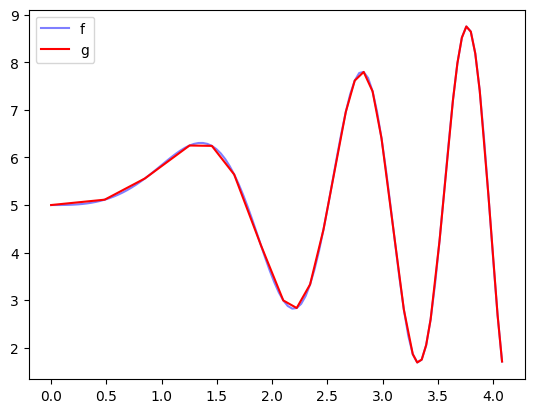

In [5]:
def build_python_model(wb):
  def relu(x):
    return max(0.0, x)

  m1, b1, m2, b2 = wb

  def f(x):
    dot = [relu(m1[i] * x + b1[i]) for i in range(len(m1))]
    sum = b2[0]
    for i in range(0, len(dot)):
        sum += dot[i] * m2[i]
    return sum
  
  return f

g = build_python_model(weights_and_biases(x, y, segments))

y2 = np.vectorize(g)(x)

plt.plot(x, y, label="f", color="blue", alpha=0.5)
plt.plot(x, y2, label="g", color="red")
plt.legend()
plt.show()

# PyTorch Model

Now let's use the same weights and biases to create a [PyTorch](https://pytorch.org/) model.

Layer 1: torch.Size([64, 1]), torch.Size([1, 64])
Layer 2: torch.Size([1, 64]), torch.Size([1, 1])
here


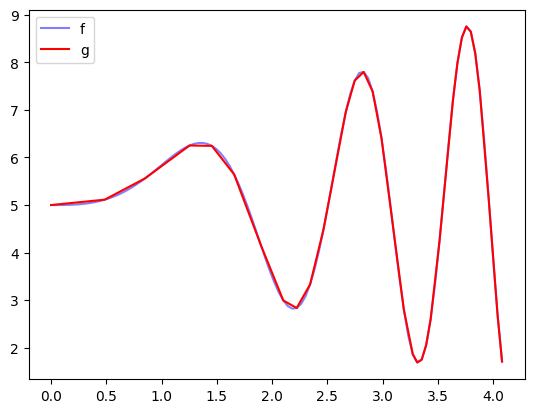

In [24]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, weights1, biases1, weights2, biases2):
        super(CustomModel, self).__init__()
        
        # Define two linear layers
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        
        # Initialize weights using the arrays provided
        self.layer1.weight = nn.Parameter(torch.tensor(weights1, dtype=torch.float32))
        self.layer1.bias = nn.Parameter(torch.tensor(biases1, dtype=torch.float32))
        self.layer2.weight = nn.Parameter(torch.tensor(weights2, dtype=torch.float32))
        self.layer2.bias = nn.Parameter(torch.tensor(biases2, dtype=torch.float32))
        print(f"Layer 1: {self.layer1.weight.shape}, {self.layer1.bias.shape}")
        print(f"Layer 2: {self.layer2.weight.shape}, {self.layer2.bias.shape}")
        print("here")

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return x

# Function to create the model
def create_model(input_size, hidden_size, output_size, weights1, biases1, weights2, biases2):
    model = CustomModel(input_size, hidden_size, output_size, weights1, biases1, weights2, biases2)
    return model

def create_model2(wb):
    (w1, b1, w2, b2) = wb
    # model = CustomModel(1, len(b1), 1, [w1], [b1], [w2], [[b2[0] + 5]])
    model = CustomModel(1, len(b1), 1, [[w] for w in w1], [b1], [w2], [b2])
    # model = CustomModel(1, len(b1), 1, [w1], [b1], [[w] for w in w2], [[b2[0] + 5]])
    def f(x):
        return model(torch.tensor([[x]], dtype=torch.float32)).item()
    return f

h = create_model2(weights_and_biases(x, y, segments))

y3 = np.vectorize(h)(x)

plt.plot(x, y, label="f", color="blue", alpha=0.5)
plt.plot(x, y3, label="g", color="red")
plt.legend()
plt.show()

### Parameters:
* input_size: Number of input features.
* hidden_size: Number of neurons in the hidden layer.
* output_size: Number of neurons in the output layer.
* weights1: Array to initialize weights for the first layer.
* weights2: Array to initialize weights for the second layer.

### Usage Example

This will create a model with two layers, initialize weights as specified, and apply ReLU activations between layers. Adjust input_size, hidden_size, and output_size as necessary for your specific use case.

In [8]:
# Define model dimensions
input_size = 4
hidden_size = 5
output_size = 3

# Define custom weights for each layer
weights1 = [[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 0.1, 0.2, 0.3], [0.4, 0.5, 0.6, 0.7], [0.8, 0.9, 0.1, 0.2]]
weights2 = [[0.1, 0.2, 0.3, 0.4, 0.5], [0.6, 0.7, 0.8, 0.9, 0.1], [0.2, 0.3, 0.4, 0.5, 0.6]]

# Create the model
model = create_model(input_size, hidden_size, output_size, weights1, weights2)

# Example input tensor (replace with your actual input data)
input_data = torch.tensor([[1.0, 2.0, 3.0, 4.0]], dtype=torch.float32)  # Batch size of 1, input size of 4

# Run inference
output = model(input_data)

# Print the output
print("Model output:", output)

Model output: tensor([[ 6.6875, 14.7760,  8.2790]], grad_fn=<ReluBackward0>)
